In [ ]:
# 包导入
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# 数据生成的参数设置
# #
hour_rate = [0.23, 0.12, 0.09, 0.10, 0.07, 0.12, 0.18, 0.23, 0.40, 0.53, 0.34, 0.28, 
             0.55, 0.58, 0.45, 0.29, 0.24, 0.23, 0.55, 0.67, 0.68, 0.43, 0.25, 0.22]
people = 300.0
down_flow = 5000.0
up_flow = 100.0
file_path = "data.tfrecord"

In [ ]:
# 数据处理
# 验证小区上的流量，标签为小区下一个小时流量
# y_true为小区下个小时的流量
# 数据集为[24,4]的张量，将([i,3]+[i,4])=y_train[]
# 数据为：平均人数，最大人数，上行流量，下行流量，总流量（标签）
# 用于训练时总流量要向后移动一小时
# #

# 写数据到TFrecord文件
# #
# 生成首个数据，接下来的数据在前23小时上加一小时
first_day = np.zeros(120)
all_day = np.zeros(1200000)
for i in range(0, 24):
    avg_people = hour_rate[i%24] * random.randint(3, 7) * people / 10
    max_people = avg_people * random.randint(2, 5)
    down_f = hour_rate[i%24] * random.randint(3, 7) * down_flow / 10
    up_f = hour_rate[i%24] * random.randint(3, 7) *  up_flow / 10
    first_day[i*5] = avg_people
    first_day[i*5+1] = max_people
    first_day[i*5+2] = up_f
    first_day[i*5+3] = down_f
    first_day[i*5+4] = (avg_people * 1.2)

# 储存第一组数据到总数据数组
for i in range(0, 120):
    all_day[i] = first_day[i] 

pre_day = first_day
for j in range(1, 10000):
    next_day = np.zeros(120)
    for m in range(0, 115):
        next_day[m] = pre_day[m+5]
        #输入新加的5个数据
        avg_people = hour_rate[j%24] * random.randint(3, 7) * people / 10
        max_people = avg_people * random.randint(2, 5) / 10
        down_f = hour_rate[j%24] * random.randint(3, 7) * down_flow / 10
        up_f = hour_rate[j%24] * random.randint(3, 7) *  up_flow / 10
        next_day[115] = avg_people
        next_day[116] = max_people
        next_day[117] = up_f
        next_day[118] = down_f
        next_day[119] = (avg_people * 1.2)
    for n in range(0, 120):
        all_day[j*120+n] = next_day[n]
    pre_day = next_day
# 写入数据
with tf.io.TFRecordWriter(file_path) as files:
    # 第一个数据的写入
    example_first = tf.train.Example(
        features=tf.train.Features(
            feature={
                "data": tf.train.Feature(
                    float_list=tf.train.FloatList(value=all_day))
                }))
    files.write(example_first.SerializePartialToString())
    


In [ ]:
# 读数据函数,返回解析后的结果
def read_datas(filepath):
    feature_description = {
        "data": tf.io.VarLenFeature(dtype=float)
    }

    file_dataset = tf.data.TFRecordDataset(filepath).batch(5)

    for serialized_example in file_dataset:
        parsed_example = tf.io.parse_example(serialized_example,                                                                                                       feature_description)
    
    return parsed_example

In [ ]:
# 数组归一化
def maxminnorm(array):
    maxcols = array.max(axis=0)
    mincols = array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t = np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

In [ ]:
# 读取数据并简单处理
datas = read_datas(file_path)["data"].values
reshape_datas = tf.reshape(datas, [240000,5])
x_data = reshape_datas[0:240000,0:4]
x_array = np.array(x_data)
y_data = tf.reshape(reshape_datas[0:240000,4], [240000,1])
y_array = np.array(y_data)

print(x_f.shape)
print(y_f.shape)

In [ ]:
# 两天的人数流量的绘制
y = np.zeros(shape=[120])
for i in range(0, 120):
    y_all_data = np.zeros(shape=[1])
    y_all_data[0] = y_array[i*24+1]
    y[i] = y_all_data

x = np.linspace(1,120,120)
plt.plot(x,y)
plt.show()

In [ ]:
# 特征数据的处理
X_all = np.zeros(shape=[10000,1,24,4,1])
for g in range(0, 10000):
    data_4 = np.zeros(shape=[1,24,4,1])
    for i in range(0, 24):
        for j in range(0, 4):
            data_4[0,i,j,0] = x_f[i+24*g,j]
    X_all[g] = data_4
X_all = X_all[0:9999,:,:,:,:]
print(X_all.shape)

In [ ]:
# y_all是每个数据张量的下一个数据张量的第一行第五列
Y_all = np.zeros(shape=[9999,1])
for i in range(0, 9999):
    y_all_data = np.zeros(shape=[1])
    y_all_data[0] = y_f[(i+1)*24+1]
    Y_all[i] = y_all_data
print(Y_all.shape)

In [ ]:
# 生成训练输入
x_train = X_all[0:7000,:,:,:,:]
y_train = Y_all[0:7000]
X_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
print(X_train)

# 生成验证输入
x_eva = X_all[7000:9000,:,:,:,:]
y_eva = Y_all[7000:9000]
X_eva = tf.data.Dataset.from_tensor_slices((x_eva,y_eva))
print(X_eva)

# 生成验证输入
x_test = X_all[9000:9999,:,:,:,:]
y_test = Y_all[9000:9999]
X_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
print(X_test)

In [ ]:
#############################################模型构建####################################################################

In [ ]:
# CNN模块创建
# 步频为1，输入输出的空间维度不变[24,4]
udn_model = keras.models.Sequential([
    keras.layers.Conv2D(128, 2, activation="relu", padding="same",
                         input_shape=[24, 4, 1]),
    keras.layers.Conv2D(64, 2, activation="relu", padding="same"),
    keras.layers.Conv2D(32, 2, activation="relu", padding="same"),
    keras.layers.Conv2D(32, 2, activation="relu", padding="same"),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(16, 2, activation="relu", padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="relu")
])

udn_model.summary()

In [ ]:
# 损失函数为负对数似然（negative log likelihood）
MeanAbsoluteError = keras.losses.MeanAbsoluteError()
# 负对数似然（negative log likelihood）没用到
def negative_log_likelihood(y_true, y_pred, eps=1e-15):
    p = keras.backend.clip(y_pred, eps, 1-eps)
    loss = keras.backend.sum(-y_true * keras.backend.log(p) - (1-y_true) * keras.backend.log(1-p))
    return keras.backend.mean(loss)


losses = MeanAbsoluteError

In [ ]:
# 编译模块
Adam = keras.optimizers.Adam(learning_rate=5e-6)

udn_model.compile(
    loss=losses,
    optimizer=Adam,
)

In [235]:
# 训练模块
# 在训练时运用mini-batch方法进行小批量梯度、
# 对每个小时进行预测
# callbacks设置
callbacks = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

history = udn_model.fit(
    X_train,
    callbacks=[callbacks],
)


Train for 7000 steps
7000/7000 [==============================] - 125s 18ms/step - loss: 21.5777


In [231]:
print(history.history)

{'loss': [23.76973969718388]}


In [236]:
# 验证模块
udn_model.evaluate(
    X_eva
)

2000/2000 [==============================] - 16s 8ms/step - loss: 18.2503


18.250277849435808

In [237]:
# 测试模块
predict_result = udn_model.predict(
    X_test
)

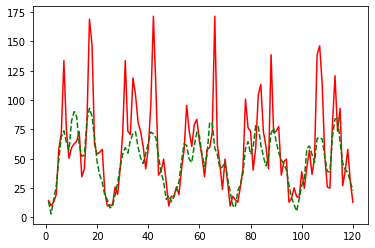

In [240]:
# 预测和真实值的对比
y1 = y_test[0:120]
y2 = predict_result[0:120]
x = np.linspace(1,120,120)

plt.plot(x, y1, color='r', label='ture')
plt.plot(x, y2, '--', color='g', label='test')
plt.show()

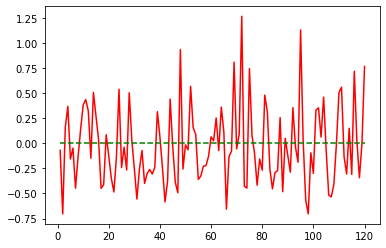

In [241]:
# 误差率图像
result_error = (y2 - y1) / y1
x = np.linspace(1,120,120)
zero = np.zeros(120)

plt.plot(x, result_error, color='r')
plt.plot(x, zero, '--', color='g')
plt.show()